<a href="https://colab.research.google.com/github/antrecord/AI_python/blob/main/%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Автоэнкодер для датасета churn

In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# Получение данных

In [ ]:
# Подключаемся к диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Читаем датасет
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/churn.csv')

In [ ]:
# Выводим первые строки датасета
dataset.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


# Распределение на классы

In [ ]:
# Разбиваем датасет по классам: 0 - клиенты, которые остались, 1 - те, которые ушли
leftDF = dataset[dataset.Churn == 1]
normalDF = dataset[dataset.Churn == 0]

In [ ]:
# Размерность датасета
leftDF.shape

(388, 20)

In [ ]:
# Размерность датасета
normalDF.shape

(2278, 20)

Посмотрим на количество звонков в службу поддержки в каждом из двух классох.

In [ ]:
leftDF.Total_day_minutes.describe()

,Total_day_minutes
count,388.000000
mean,205.181186
std,68.490213
min,0.000000
25%,150.900000
50%,214.950000
75%,262.200000
max,350.800000


In [ ]:
normalDF.Total_day_minutes.describe()

,Total_day_minutes
count,2278.000000
mean,175.104346
std,50.105334
min,0.000000
25%,142.500000
50%,177.900000
75%,209.800000
max,313.800000


В среднем звонков поступает больше от людей, которые ушли

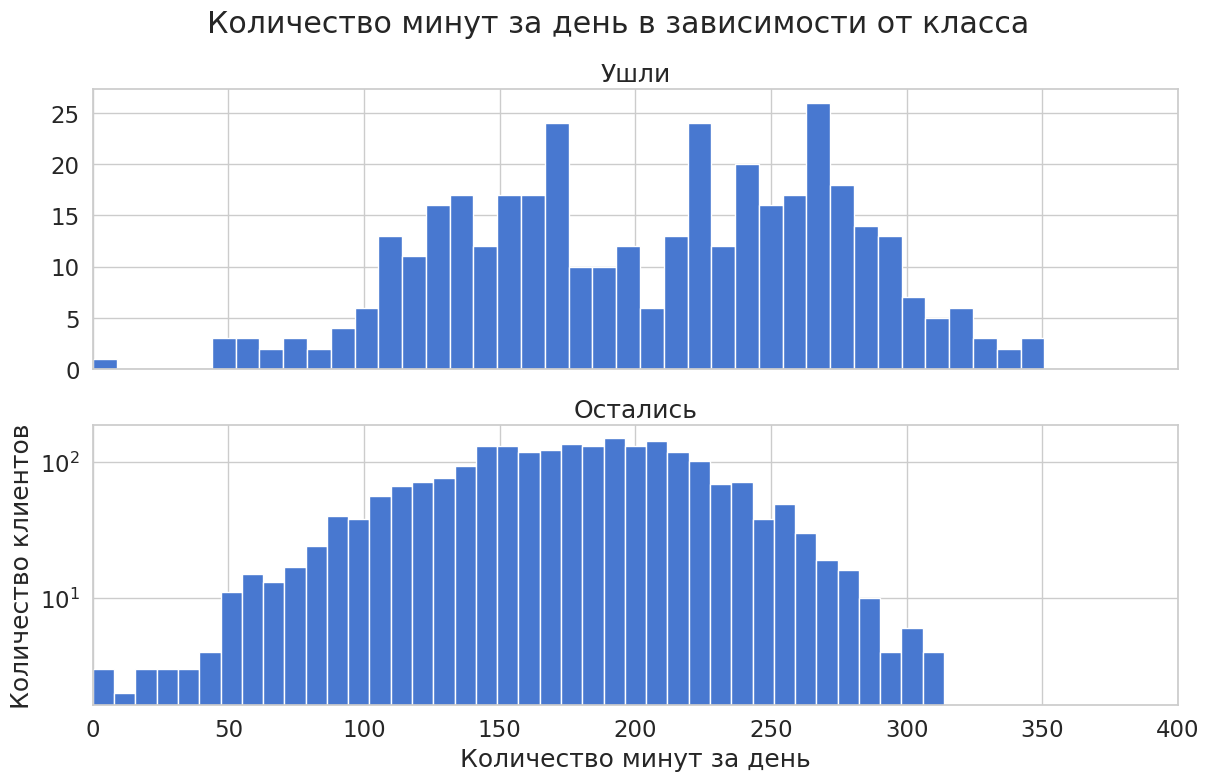

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Количество минут за день в зависимости от класса')

bins = 40

ax1.hist(leftDF.Total_day_minutes, bins = bins)
ax1.set_title('Ушли')

ax2.hist(normalDF.Total_day_minutes, bins = bins)
ax2.set_title('Остались')

plt.xlabel('Количество минут за день')
plt.ylabel('Количество клиентов')
plt.xlim((0, 400))
plt.yscale('log')
plt.show()

Посмотрим, влияет ли код региона на уход клиентов?

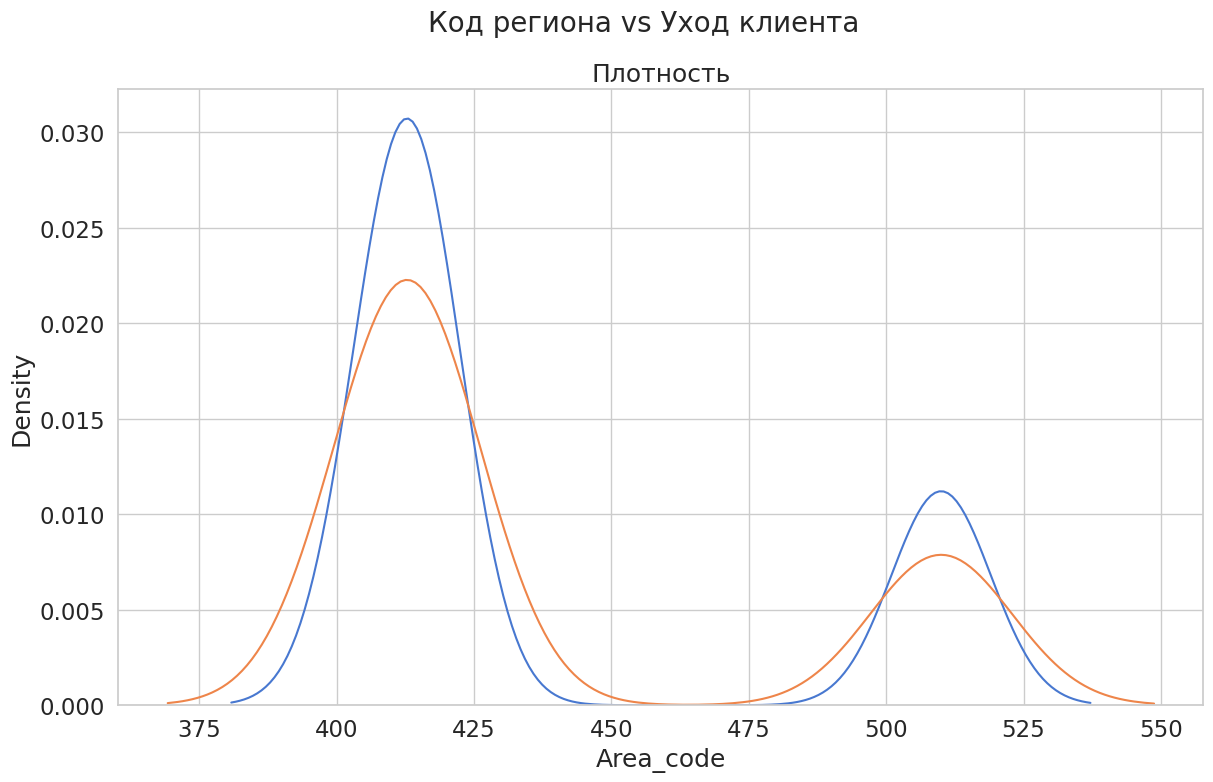

In [ ]:
# Построим графики распределения переменной x для каждого класса целевой переменной
x = "Area_code"
fig, ax = plt.subplots() # Распаковываем  кортеж в переменные fig и ax.
# Получаем объект рисунка и массив подграфиков, где первое число - количество строк, второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
fig.suptitle('Код региона vs Уход клиента', fontsize=20) # Название

# Распределение
ax.title.set_text('Плотность')
for i in dataset.Churn.unique():  # Перебираем все уникальные значения в столбце Churn
    sns.kdeplot(dataset[dataset.Churn==i][x], label=i, ax=ax) # Построим график плотности распределения столбца x, при условии, что значение в столбце целевой переменной совпадет с i
ax.grid(True) # Настроим линии сетки.

plt.show()

Видно, что код региона не влияет на уход клиента

Text(0.5, 1.0, 'Корреляция Пирсона')

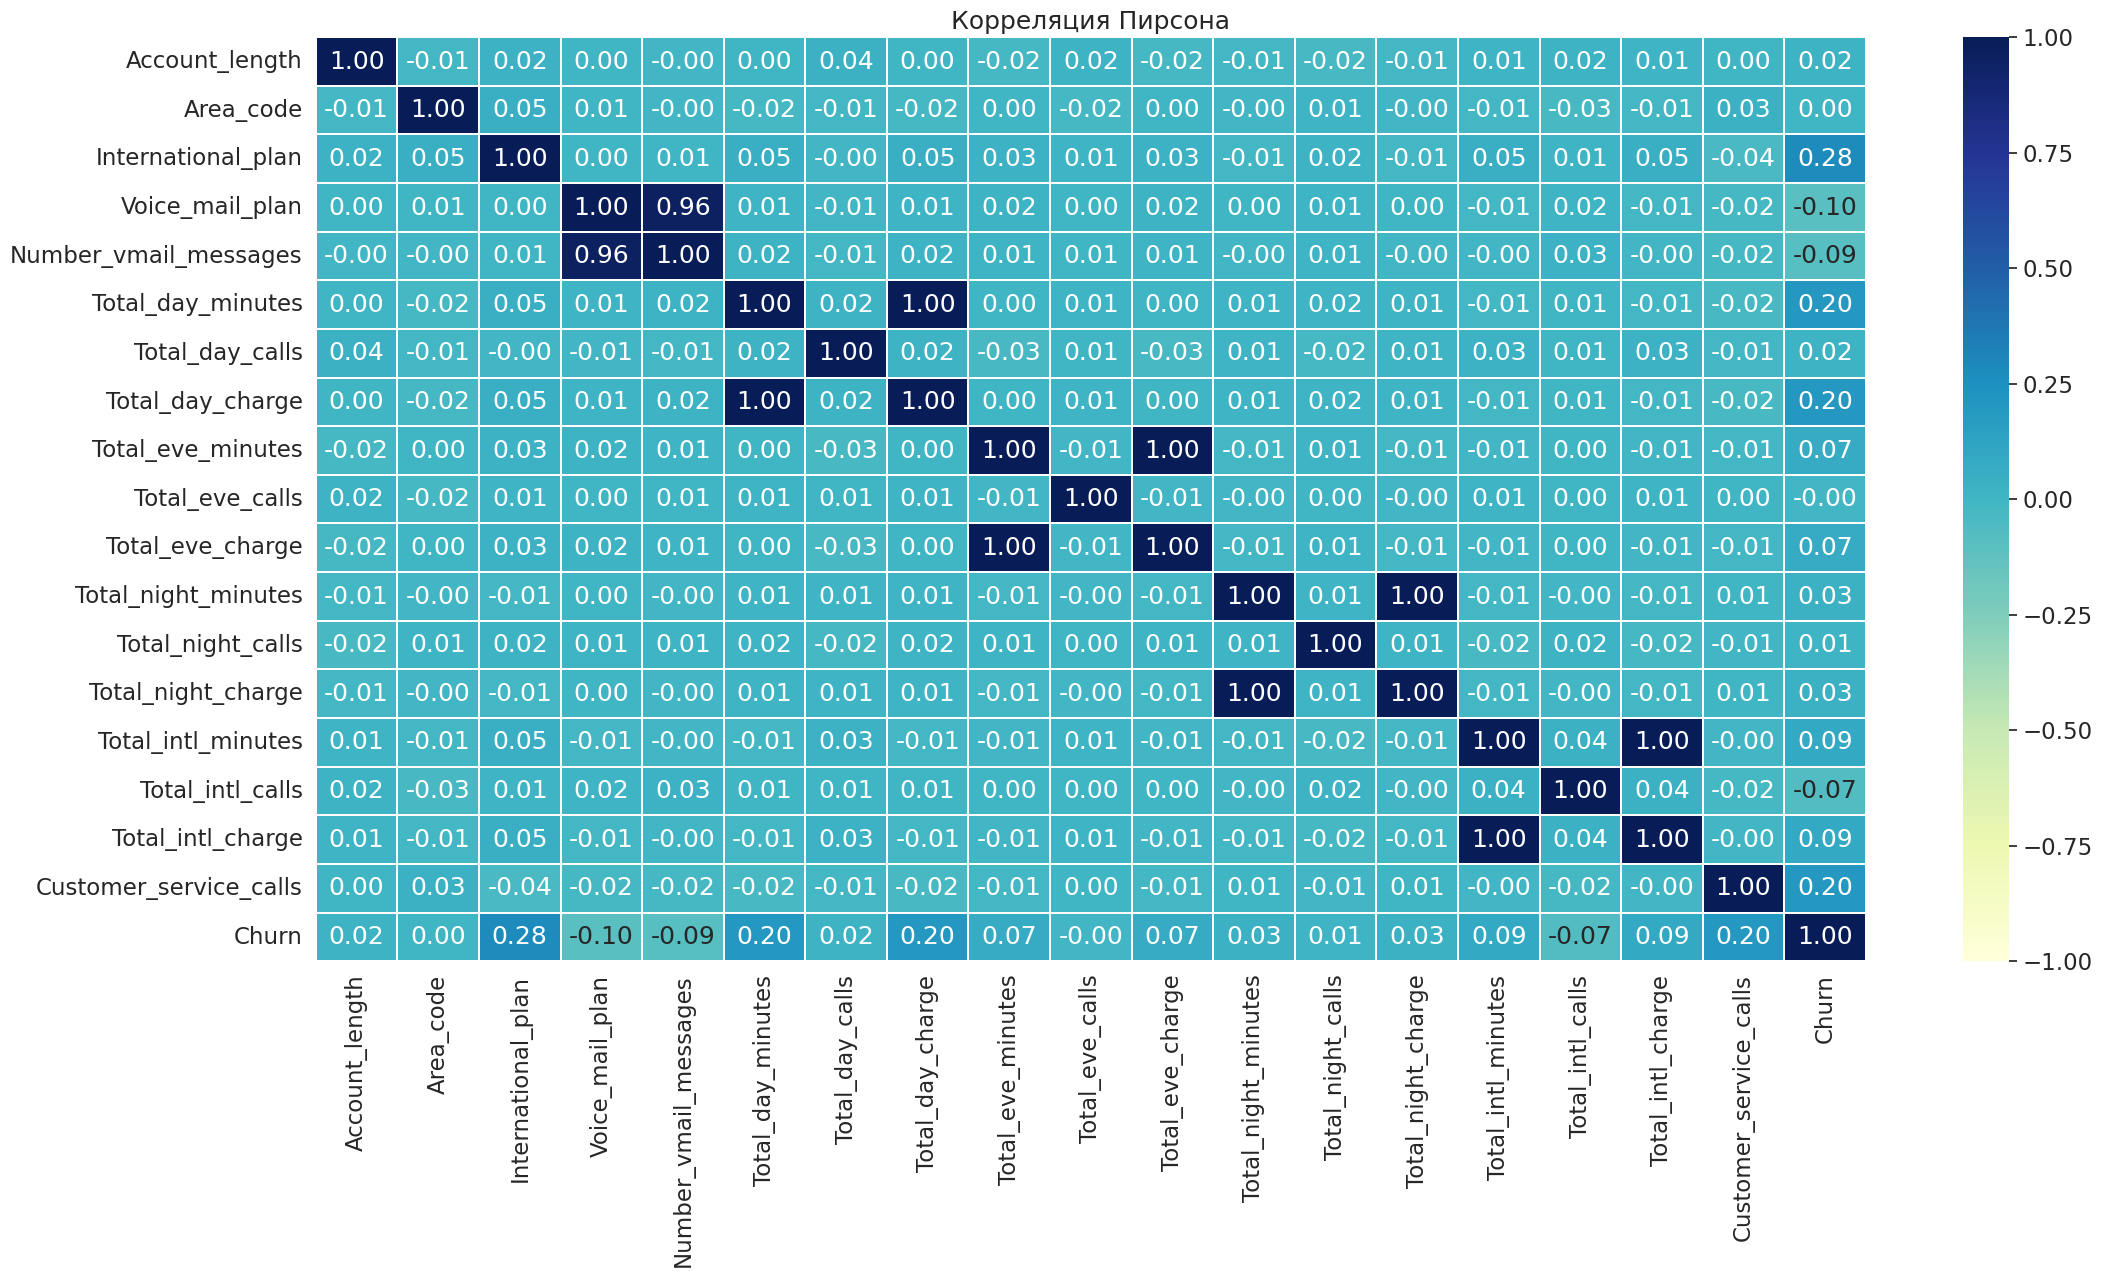

In [ ]:
# Вычисляем матрицу корреляций
corr_matrix = dataset.copy()
corr_matrix = corr_matrix.drop('State', axis=1).replace('No', 0).replace('Yes', 1)
plt.figure(figsize=(25,12),dpi=100)

corr_matrix = corr_matrix.corr(method="pearson")
# Визуализируем матрицу корреляции
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.2)
plt.title("Корреляция Пирсона")

In [ ]:
# Удаляем столбцы неинформативные столбцы, столбцы с 0 корреляцией и сильно коррелирующие столбцы
col_for_delete = ['State', 'Area_code', 'Total_eve_calls', 'Number_vmail_messages', 'Total_day_charge', 'Total_eve_charge', 'Total_night_charge', 'Total_intl_charge']
dataset = dataset.drop(col_for_delete, axis=1)
dataset.head()

,Account_length,International_plan,Voice_mail_plan,Total_day_minutes,Total_day_calls,Total_eve_minutes,Total_night_minutes,Total_night_calls,Total_intl_minutes,Total_intl_calls,Customer_service_calls,Churn
0,128,No,Yes,265.1,110,197.4,244.7,91,10.0,3,1,False
1,107,No,Yes,161.6,123,195.5,254.4,103,13.7,3,1,False
2,137,No,No,243.4,114,121.2,162.6,104,12.2,5,0,False
3,84,Yes,No,299.4,71,61.9,196.9,89,6.6,7,2,False
4,75,Yes,No,166.7,113,148.3,186.9,121,10.1,3,3,False


#Обработка данных

In [ ]:
# Заменим пробелы на NaN и проверим, сколько пропущеных значений в датасете
dataset = dataset.replace(' ', np.NaN)
np.count_nonzero(dataset.isnull().sum(axis= 1).values)

0

Пропущенные значения отсутствуют

In [ ]:
# Выводим информацию о датасете
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account_length          2666 non-null   int64  
 1   International_plan      2666 non-null   object 
 2   Voice_mail_plan         2666 non-null   object 
 3   Total_day_minutes       2666 non-null   float64
 4   Total_day_calls         2666 non-null   int64  
 5   Total_eve_minutes       2666 non-null   float64
 6   Total_night_minutes     2666 non-null   float64
 7   Total_night_calls       2666 non-null   int64  
 8   Total_intl_minutes      2666 non-null   float64
 9   Total_intl_calls        2666 non-null   int64  
 10  Customer_service_calls  2666 non-null   int64  
 11  Churn                   2666 non-null   bool   
dtypes: bool(1), float64(4), int64(5), object(2)
memory usage: 231.8+ KB


In [ ]:
# Заменяем категориальные переменные
dataset = dataset.replace('Yes', 1).replace('No', 0)

In [ ]:
# Выводим информацию о датасете
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account_length          2666 non-null   int64  
 1   International_plan      2666 non-null   int64  
 2   Voice_mail_plan         2666 non-null   int64  
 3   Total_day_minutes       2666 non-null   float64
 4   Total_day_calls         2666 non-null   int64  
 5   Total_eve_minutes       2666 non-null   float64
 6   Total_night_minutes     2666 non-null   float64
 7   Total_night_calls       2666 non-null   int64  
 8   Total_intl_minutes      2666 non-null   float64
 9   Total_intl_calls        2666 non-null   int64  
 10  Customer_service_calls  2666 non-null   int64  
 11  Churn                   2666 non-null   bool   
dtypes: bool(1), float64(4), int64(7)
memory usage: 231.8 KB


In [ ]:
# Датасет без категориальных переменных
dataset.head()

,Account_length,International_plan,Voice_mail_plan,Total_day_minutes,Total_day_calls,Total_eve_minutes,Total_night_minutes,Total_night_calls,Total_intl_minutes,Total_intl_calls,Customer_service_calls,Churn
0,128,0,1,265.1,110,197.4,244.7,91,10.0,3,1,False
1,107,0,1,161.6,123,195.5,254.4,103,13.7,3,1,False
2,137,0,0,243.4,114,121.2,162.6,104,12.2,5,0,False
3,84,1,0,299.4,71,61.9,196.9,89,6.6,7,2,False
4,75,1,0,166.7,113,148.3,186.9,121,10.1,3,3,False


Нормализуем данные

In [ ]:
X = dataset.copy()

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=dataset.columns, index=dataset.index)
X.head() # Смотрим, как прошла нормализация

,Account_length,International_plan,Voice_mail_plan,Total_day_minutes,Total_day_calls,Total_eve_minutes,Total_night_minutes,Total_night_calls,Total_intl_minutes,Total_intl_calls,Customer_service_calls,Churn
0,0.524793,0.0,1.0,0.755701,0.68750,0.542755,0.572161,0.436090,0.500,0.15,0.111111,0.0
1,0.438017,0.0,1.0,0.460661,0.76875,0.537531,0.599772,0.526316,0.685,0.15,0.111111,0.0
2,0.561983,0.0,0.0,0.693843,0.71250,0.333242,0.338457,0.533835,0.610,0.25,0.000000,0.0
3,0.342975,1.0,0.0,0.853478,0.44375,0.170195,0.436095,0.421053,0.330,0.35,0.222222,0.0
4,0.305785,1.0,0.0,0.475200,0.70625,0.407754,0.407629,0.661654,0.505,0.15,0.333333,0.0


Выведем параметры нашего датасета

In [ ]:
X.shape

(2666, 12)

In [ ]:
X.describe()

,Account_length,International_plan,Voice_mail_plan,Total_day_minutes,Total_day_calls,Total_eve_minutes,Total_night_minutes,Total_night_calls,Total_intl_minutes,Total_intl_calls,Customer_service_calls,Churn
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,0.411655,0.101275,0.274944,0.511635,0.626939,0.550966,0.448246,0.504558,0.511851,0.223368,0.173627,0.145536
std,0.163487,0.301750,0.446570,0.154533,0.124926,0.140092,0.144550,0.146003,0.139417,0.122810,0.145693,0.352707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.297521,0.000000,0.000000,0.408780,0.543750,0.454495,0.350769,0.406015,0.425000,0.150000,0.111111,0.000000
50%,0.409091,0.000000,0.000000,0.512970,0.631250,0.552378,0.448192,0.503759,0.510000,0.200000,0.111111,0.000000
75%,0.520661,0.000000,1.000000,0.615450,0.712500,0.646412,0.548748,0.601504,0.605000,0.300000,0.222222,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Разделение на обучающую и тестовую выборки

In [ ]:
# Разделяем на тестовую и обучающую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=12)
X_train = X_train[X_train.Churn == 0] # Обучать будем на клиентах, которые не ушли
X_train = X_train.drop(['Churn'], axis=1) # Удаляем целевую перменную
y_test = X_test['Churn'] # Целевая переменная
X_test = X_test.drop(['Churn'], axis=1) # Удаляем целевую перменную

# Получаем значения
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
# Размер тестовой выборки
print(y_test.size)


534


# Строим и обучаем модель модель

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 7),
            nn.Tanh(),
            nn.Linear(7, 4),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(4, 7),
           nn.Tanh(),
           nn.Linear(7, 11),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().double()

In [ ]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

In [ ]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [ ]:
history = {}
history['train_loss'] = []

In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.1589
epoch [2/100], loss:0.1317
epoch [3/100], loss:0.1006
epoch [4/100], loss:0.0626
epoch [5/100], loss:0.0403
epoch [6/100], loss:0.0217
epoch [7/100], loss:0.0204
epoch [8/100], loss:0.0201
epoch [9/100], loss:0.0200
epoch [10/100], loss:0.0198
epoch [11/100], loss:0.0196
epoch [12/100], loss:0.0193
epoch [13/100], loss:0.0189
epoch [14/100], loss:0.0180
epoch [15/100], loss:0.0168
epoch [16/100], loss:0.0157
epoch [17/100], loss:0.0151
epoch [18/100], loss:0.0146
epoch [19/100], loss:0.0144
epoch [20/100], loss:0.0142
epoch [21/100], loss:0.0141
epoch [22/100], loss:0.0140
epoch [23/100], loss:0.0140
epoch [24/100], loss:0.0139
epoch [25/100], loss:0.0139
epoch [26/100], loss:0.0139
epoch [27/100], loss:0.0138
epoch [28/100], loss:0.0138
epoch [29/100], loss:0.0138
epoch [30/100], loss:0.0138
epoch [31/100], loss:0.0137
epoch [32/100], loss:0.0137
epoch [33/100], loss:0.0137
epoch [34/100], loss:0.0136
epoch [35/100], loss:0.0136
epoch [36/100], loss:0.0135
e

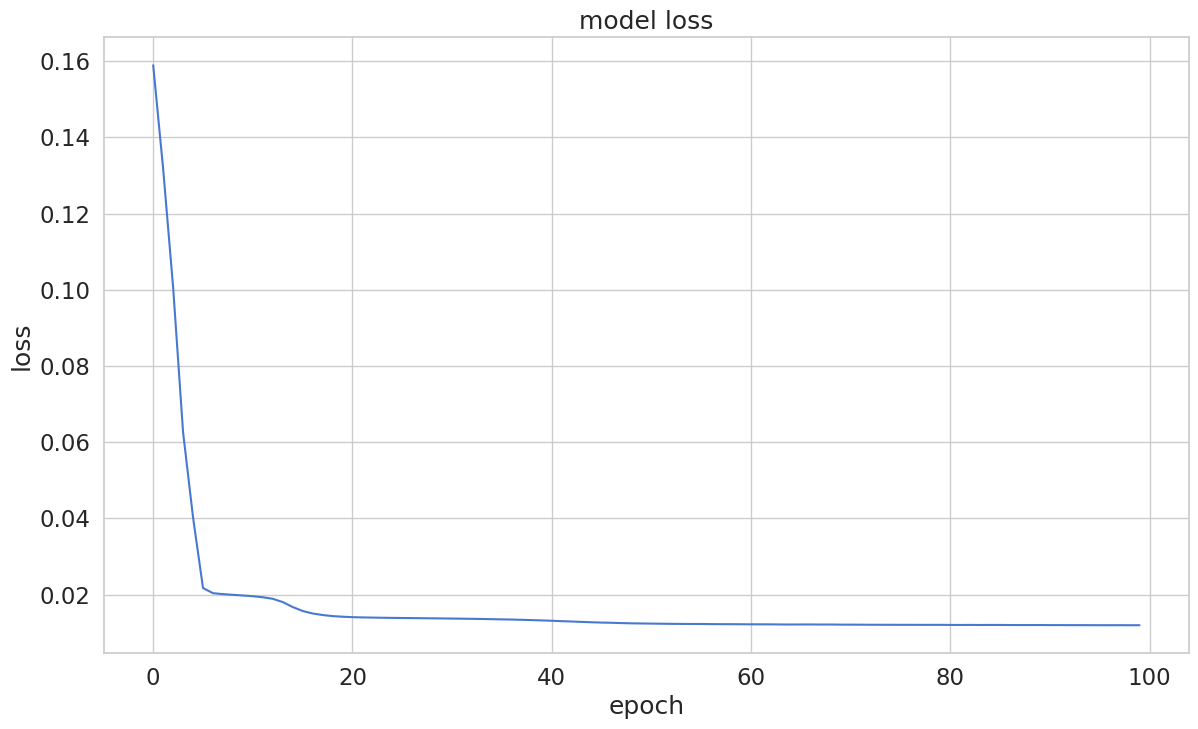

In [ ]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Предсказание значений на тестовой выборке

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Churn'] = y_test

In [ ]:
reconstructionErrorDF

,pred_loss,Churn
0,0.007347,0.0
1,0.003631,0.0
2,0.010022,0.0
3,0.003777,0.0
4,0.008691,0.0
...,...,...
529,0.007818,0.0
530,0.012502,0.0
531,0.009502,0.0
532,0.023747,0.0


# Ошибки для оставшихся клиентов

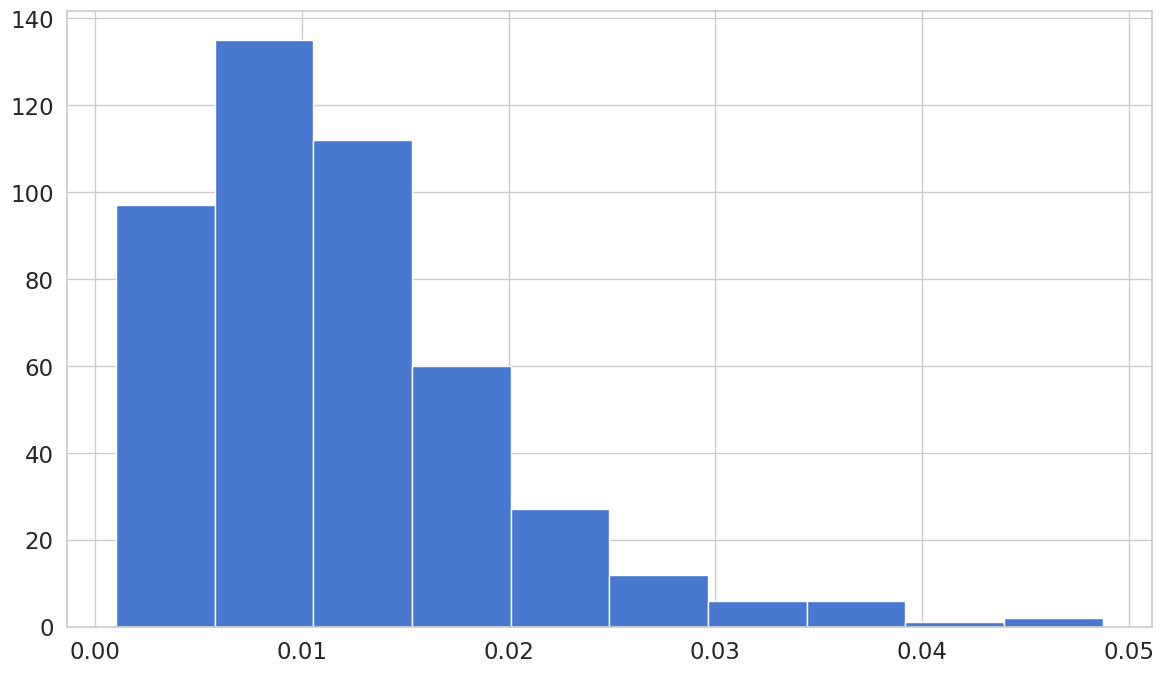

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Churn']== 0)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Ошибки для ушедших клиентов

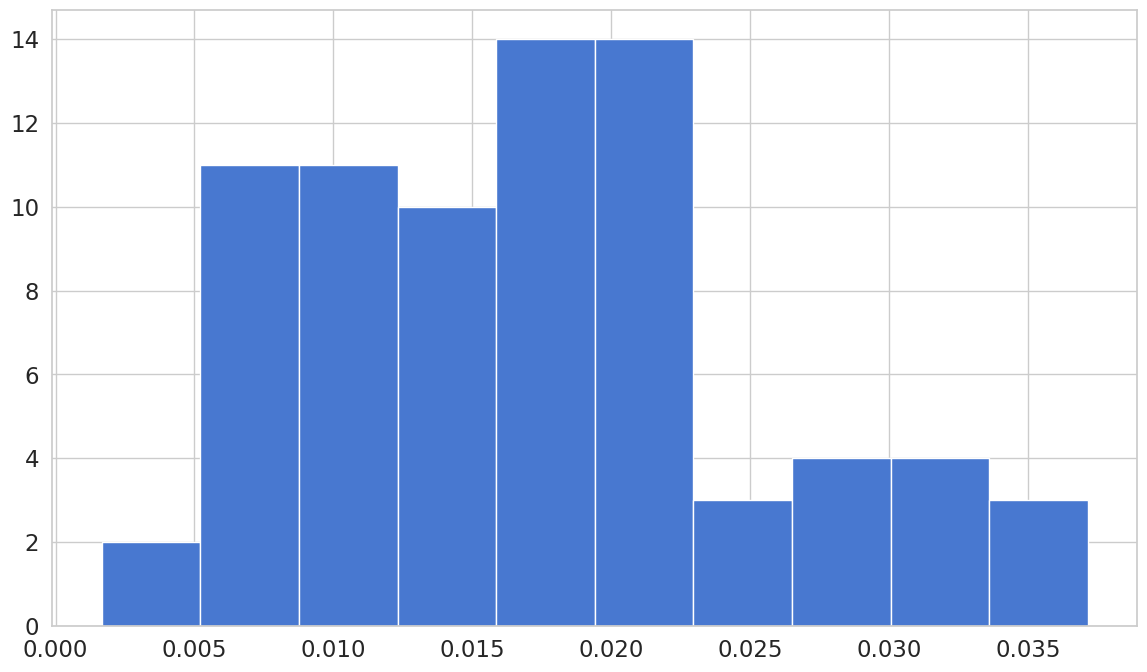

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Churn']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

# ROC Кривые

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

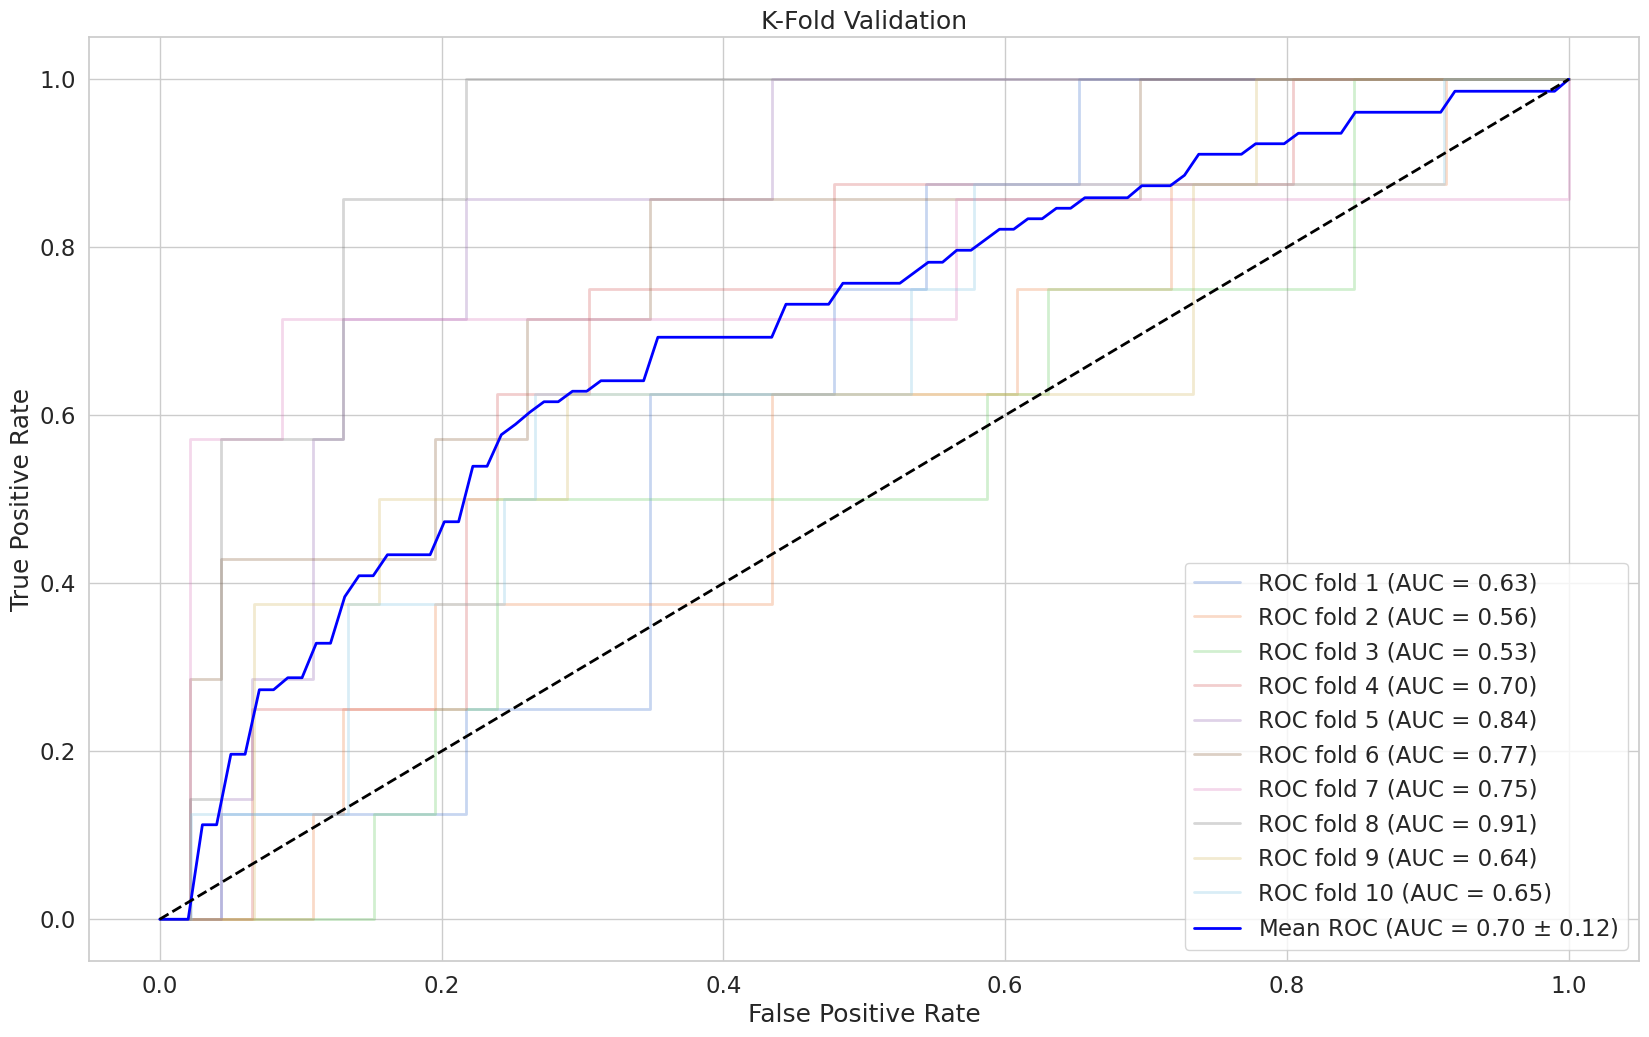

In [ ]:
# Параметры для K-Fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

# Построение семейства ROC-кривых
fig = plt.figure(figsize=(20, 12), dpi=100)
i = 1

for train_idx, test_idx in cv.split(X_test, y_test):
    # Разделяем данные на обучающие и тестовые для текущей итерации
    X_train_fold = X_test[train_idx]
    y_train_fold = y_test[train_idx]
    X_test_fold = X_test[test_idx]
    y_test_fold = y_test[test_idx]

    # Рассчитываем ошибки реконструкции для тестовой выборки
    model.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for data in X_test_fold:
            data = torch.tensor(data).unsqueeze(0).double()
            outputs = model(data)
            loss = criterion(outputs, data).item()
            reconstruction_errors.append(loss)

    # Строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test_fold, reconstruction_errors, pos_label=1)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    i += 1

# Средние значения и доверительный интервал
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=1)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

# Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

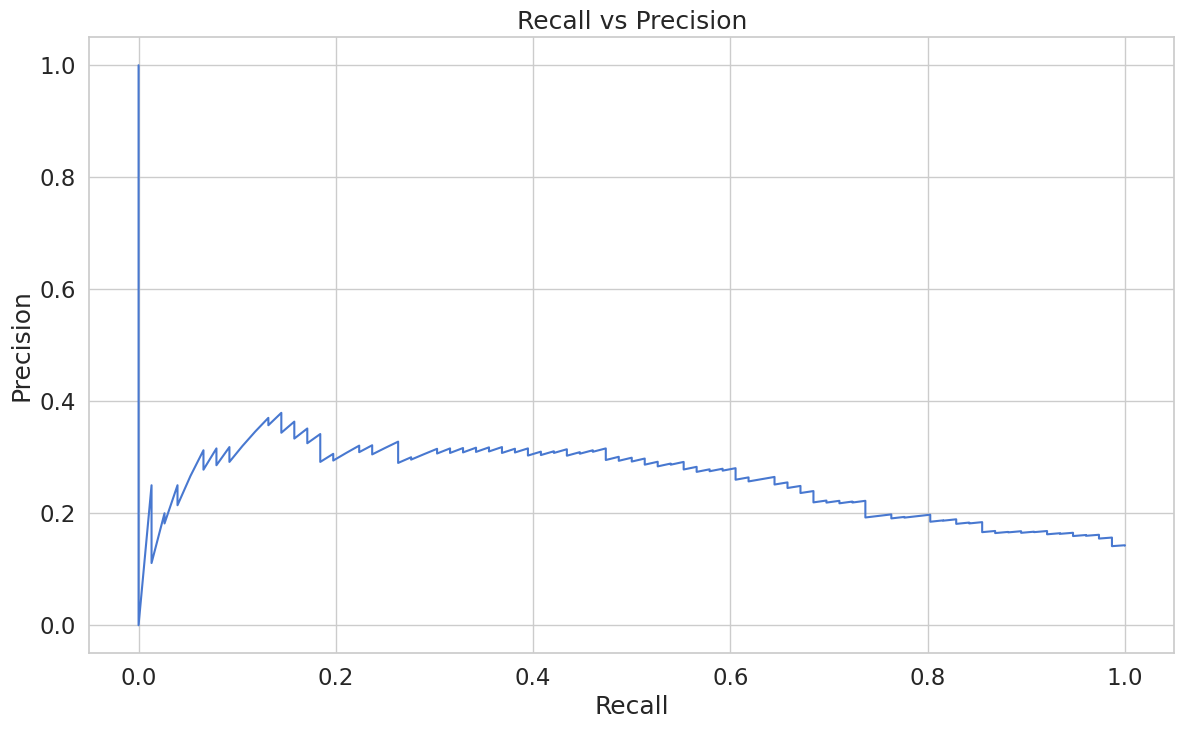

In [ ]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Churn, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

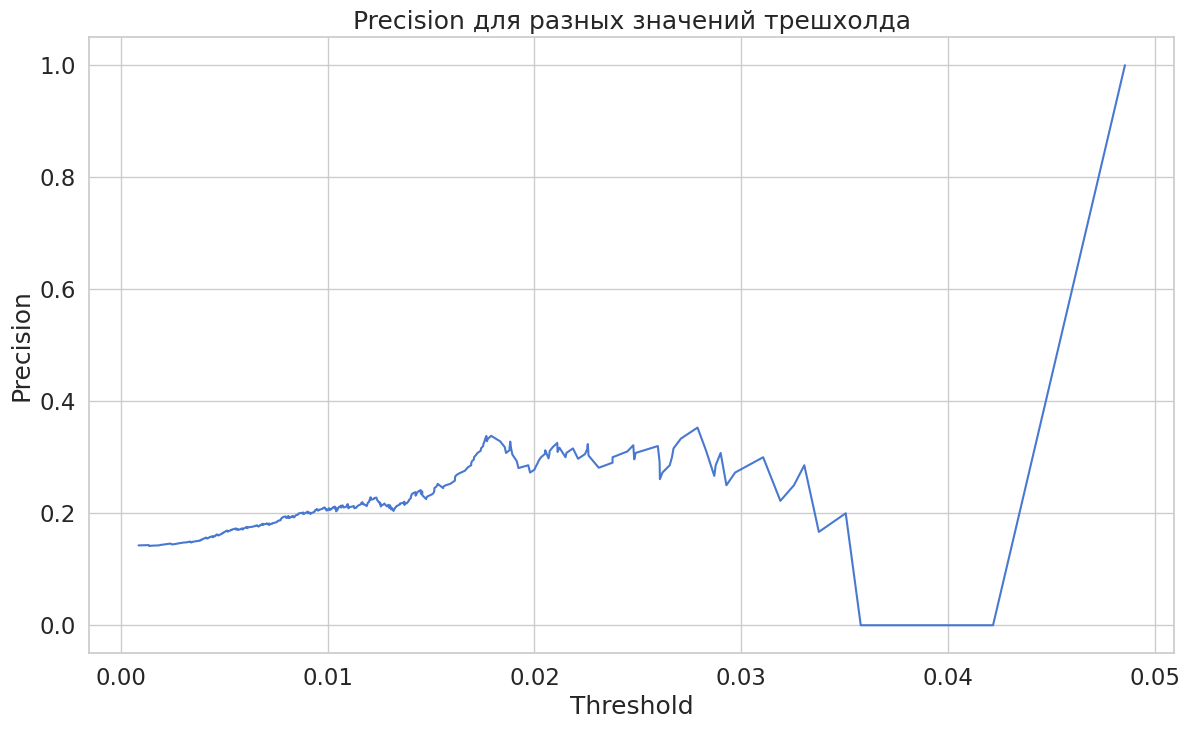

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


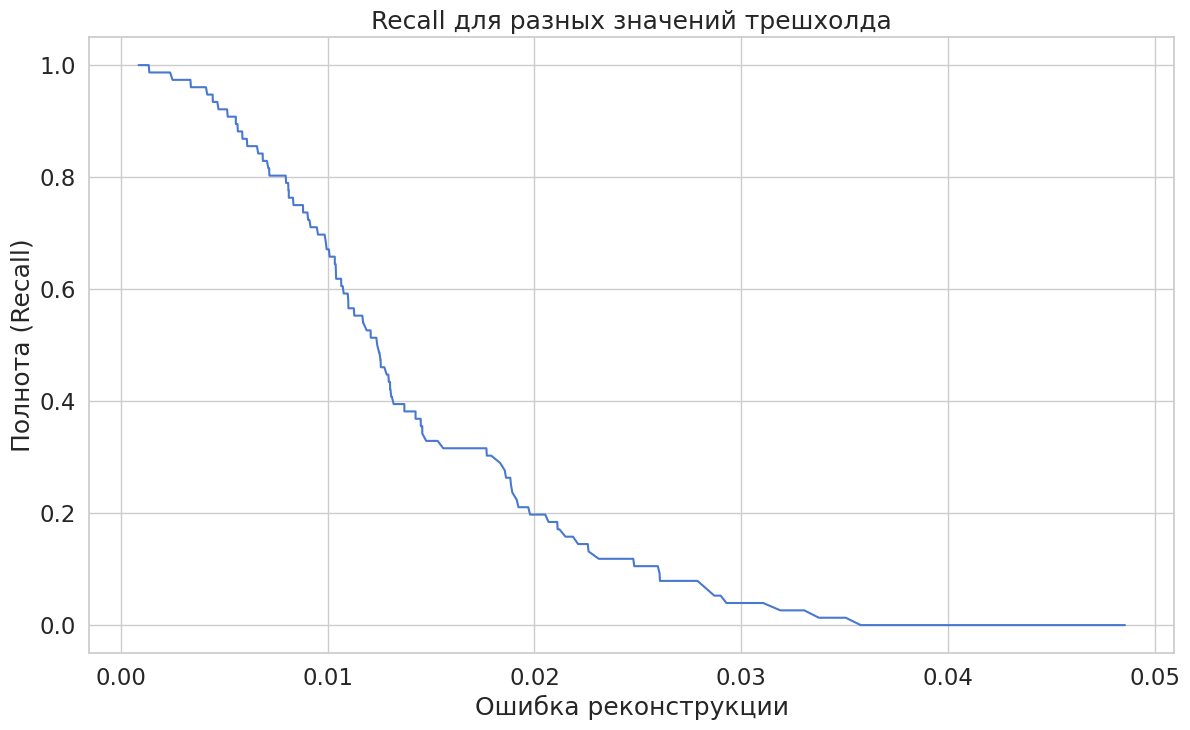

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

# Используем модель для того, чтобы сделать предсказание

In [ ]:
threshold = 0.015

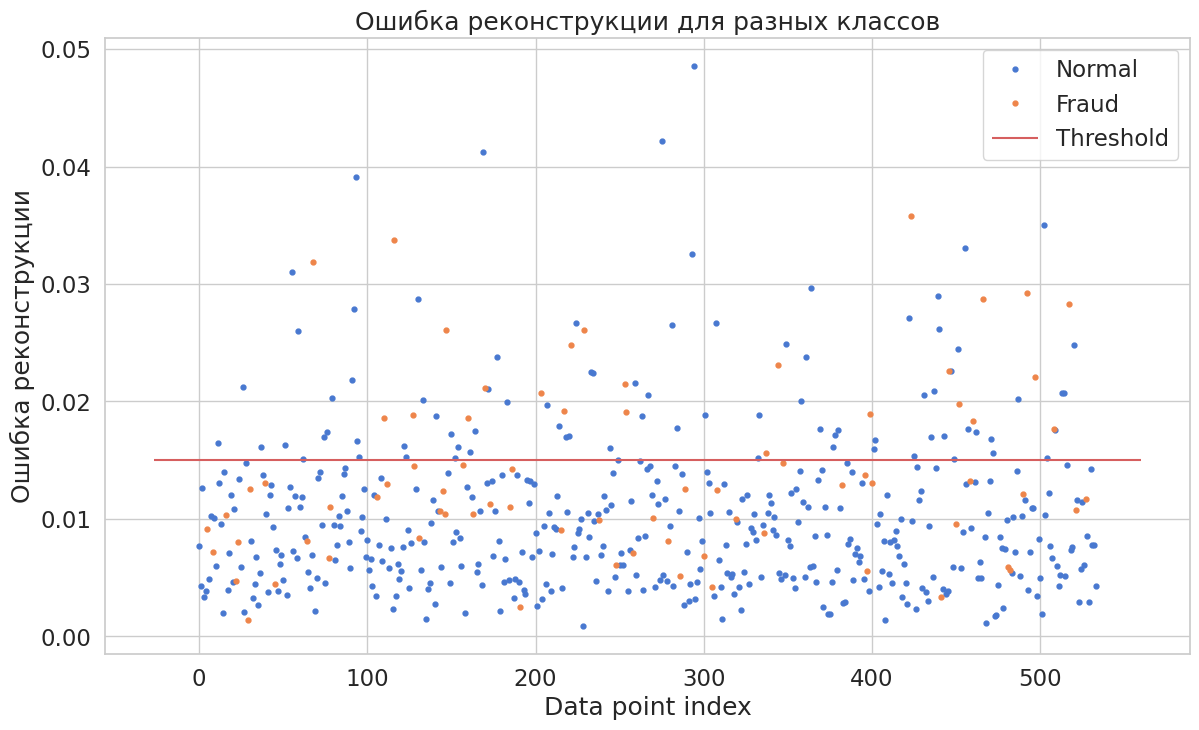

In [ ]:
groups = reconstructionErrorDF.groupby('Churn')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

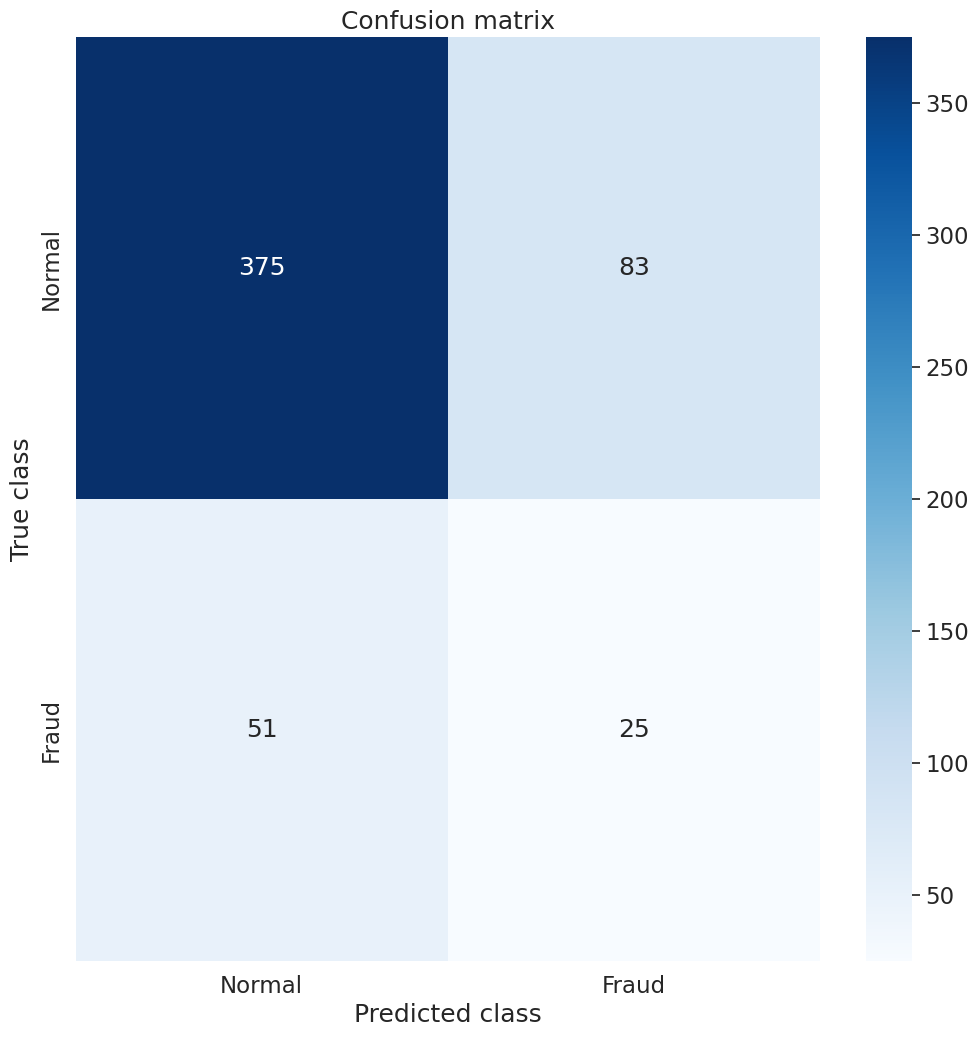

In [ ]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Churn, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Автоэнкодер для датасета card_transdata

In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# Получение данных

In [ ]:
# Подключаемся к диску
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ссылка на датасет: https://www.kaggle.com/datasets/elakiyasekar/card-transdata/data

In [ ]:
# Читаем датасет
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/card_transdata.csv')

In [ ]:
# Выводим первые строки датасета
dataset.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Информация о датасете:

distance_from_home - расстояние от дома

distance_from_last_transaction - расстояние от последней транзакции

ratio_to_median_purchase_price - средняя цена покупки

repeat_retailer - повторение продовца

used_chip - использован чип

used_pin_number - использован пин-код

online_order - онлайн заказ

fraud - 1 - мошенническая транзакция / 0 - нет

# Распределение на классы

In [ ]:
# Разбиваем датасет по классам: 0 - нормальные транзакции, 1 - мошеннические
fraudDF = dataset[dataset.fraud == 1]
normalDF = dataset[dataset.fraud == 0]

In [ ]:
# Размерность датасета
fraudDF.shape

(87403, 8)

In [ ]:
# Размерность датасета
normalDF.shape

(912597, 8)

Посмотрим на онлайн-заказы в каждом из двух классох.

In [ ]:
fraudDF.online_order.describe()

,online_order
count,87403.000000
mean,0.946318
std,0.225391
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
normalDF.online_order.describe()

,online_order
count,912597.000000
mean,0.622225
std,0.484831
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


В среднем мешеннические транзакции больше совершаются в онлайн-заказах.

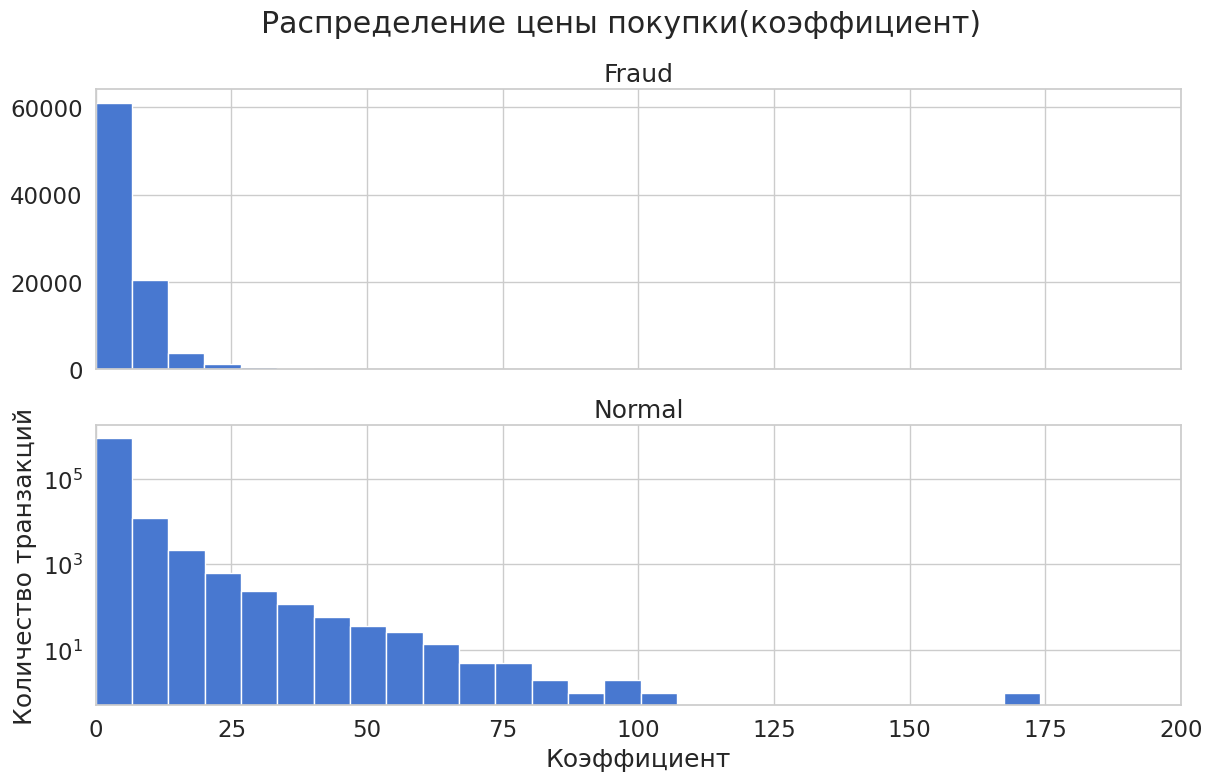

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Распределение цены покупки(коэффициент)')

bins = 40

ax1.hist(fraudDF.ratio_to_median_purchase_price, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.ratio_to_median_purchase_price, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Коэффициент')
plt.ylabel('Количество транзакций')
plt.xlim((0, 200))
plt.yscale('log')
plt.show()

Посмотрим, влияет ли покупка у одного и того же продавца?

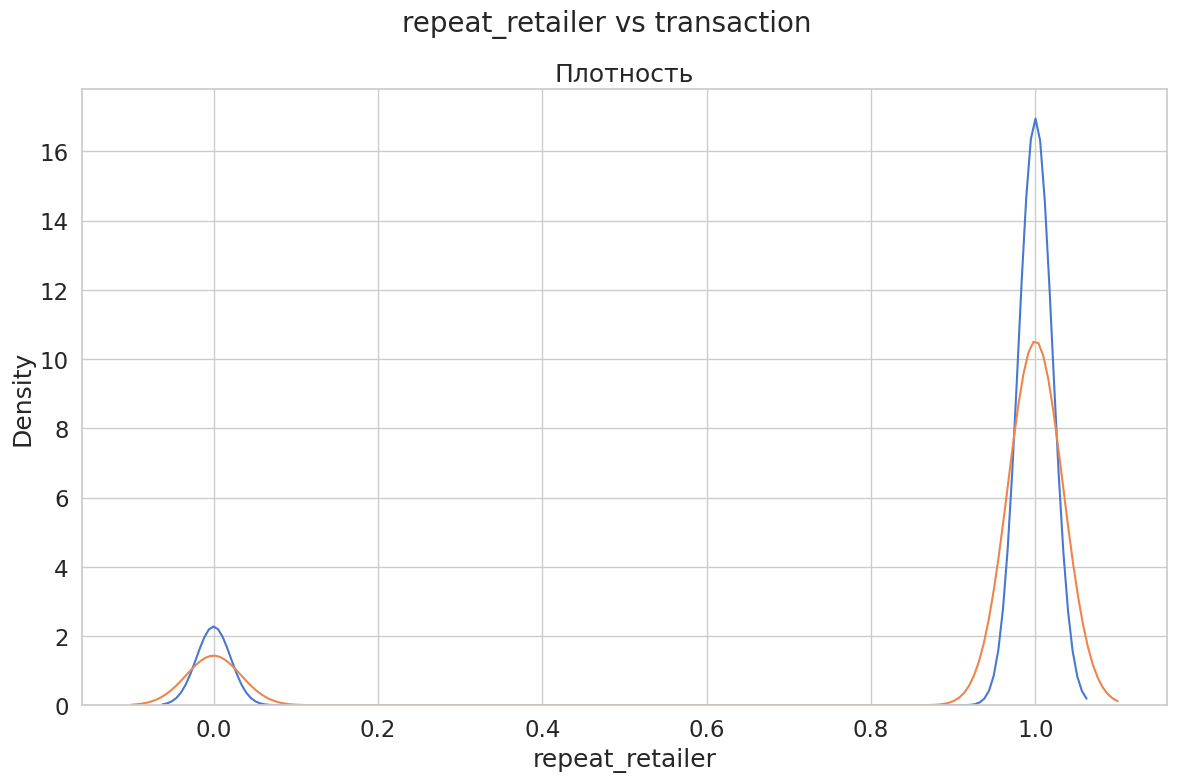

In [ ]:
# Построим графики распределения переменной x для каждого класса целевой переменной
x = "repeat_retailer"
fig, ax = plt.subplots() # Распаковываем  кортеж в переменные fig и ax.
# Получаем объект рисунка и массив подграфиков, где первое число - количество строк, второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
fig.suptitle('repeat_retailer vs transaction', fontsize=20) # Название

# Распределение
ax.title.set_text('Плотность')
for i in dataset.fraud.unique():  # Перебираем все уникальные значения в столбце Churn
    sns.kdeplot(dataset[dataset.fraud==i][x], label=i, ax=ax) # Построим график плотности распределения столбца x, при условии, что значение в столбце целевой переменной совпадет с i
ax.grid(True) # Настроим линии сетки.

plt.show()

Видно, что покупка у одного и того же продавца не влияет

Text(0.5, 1.0, 'Корреляция Пирсона')

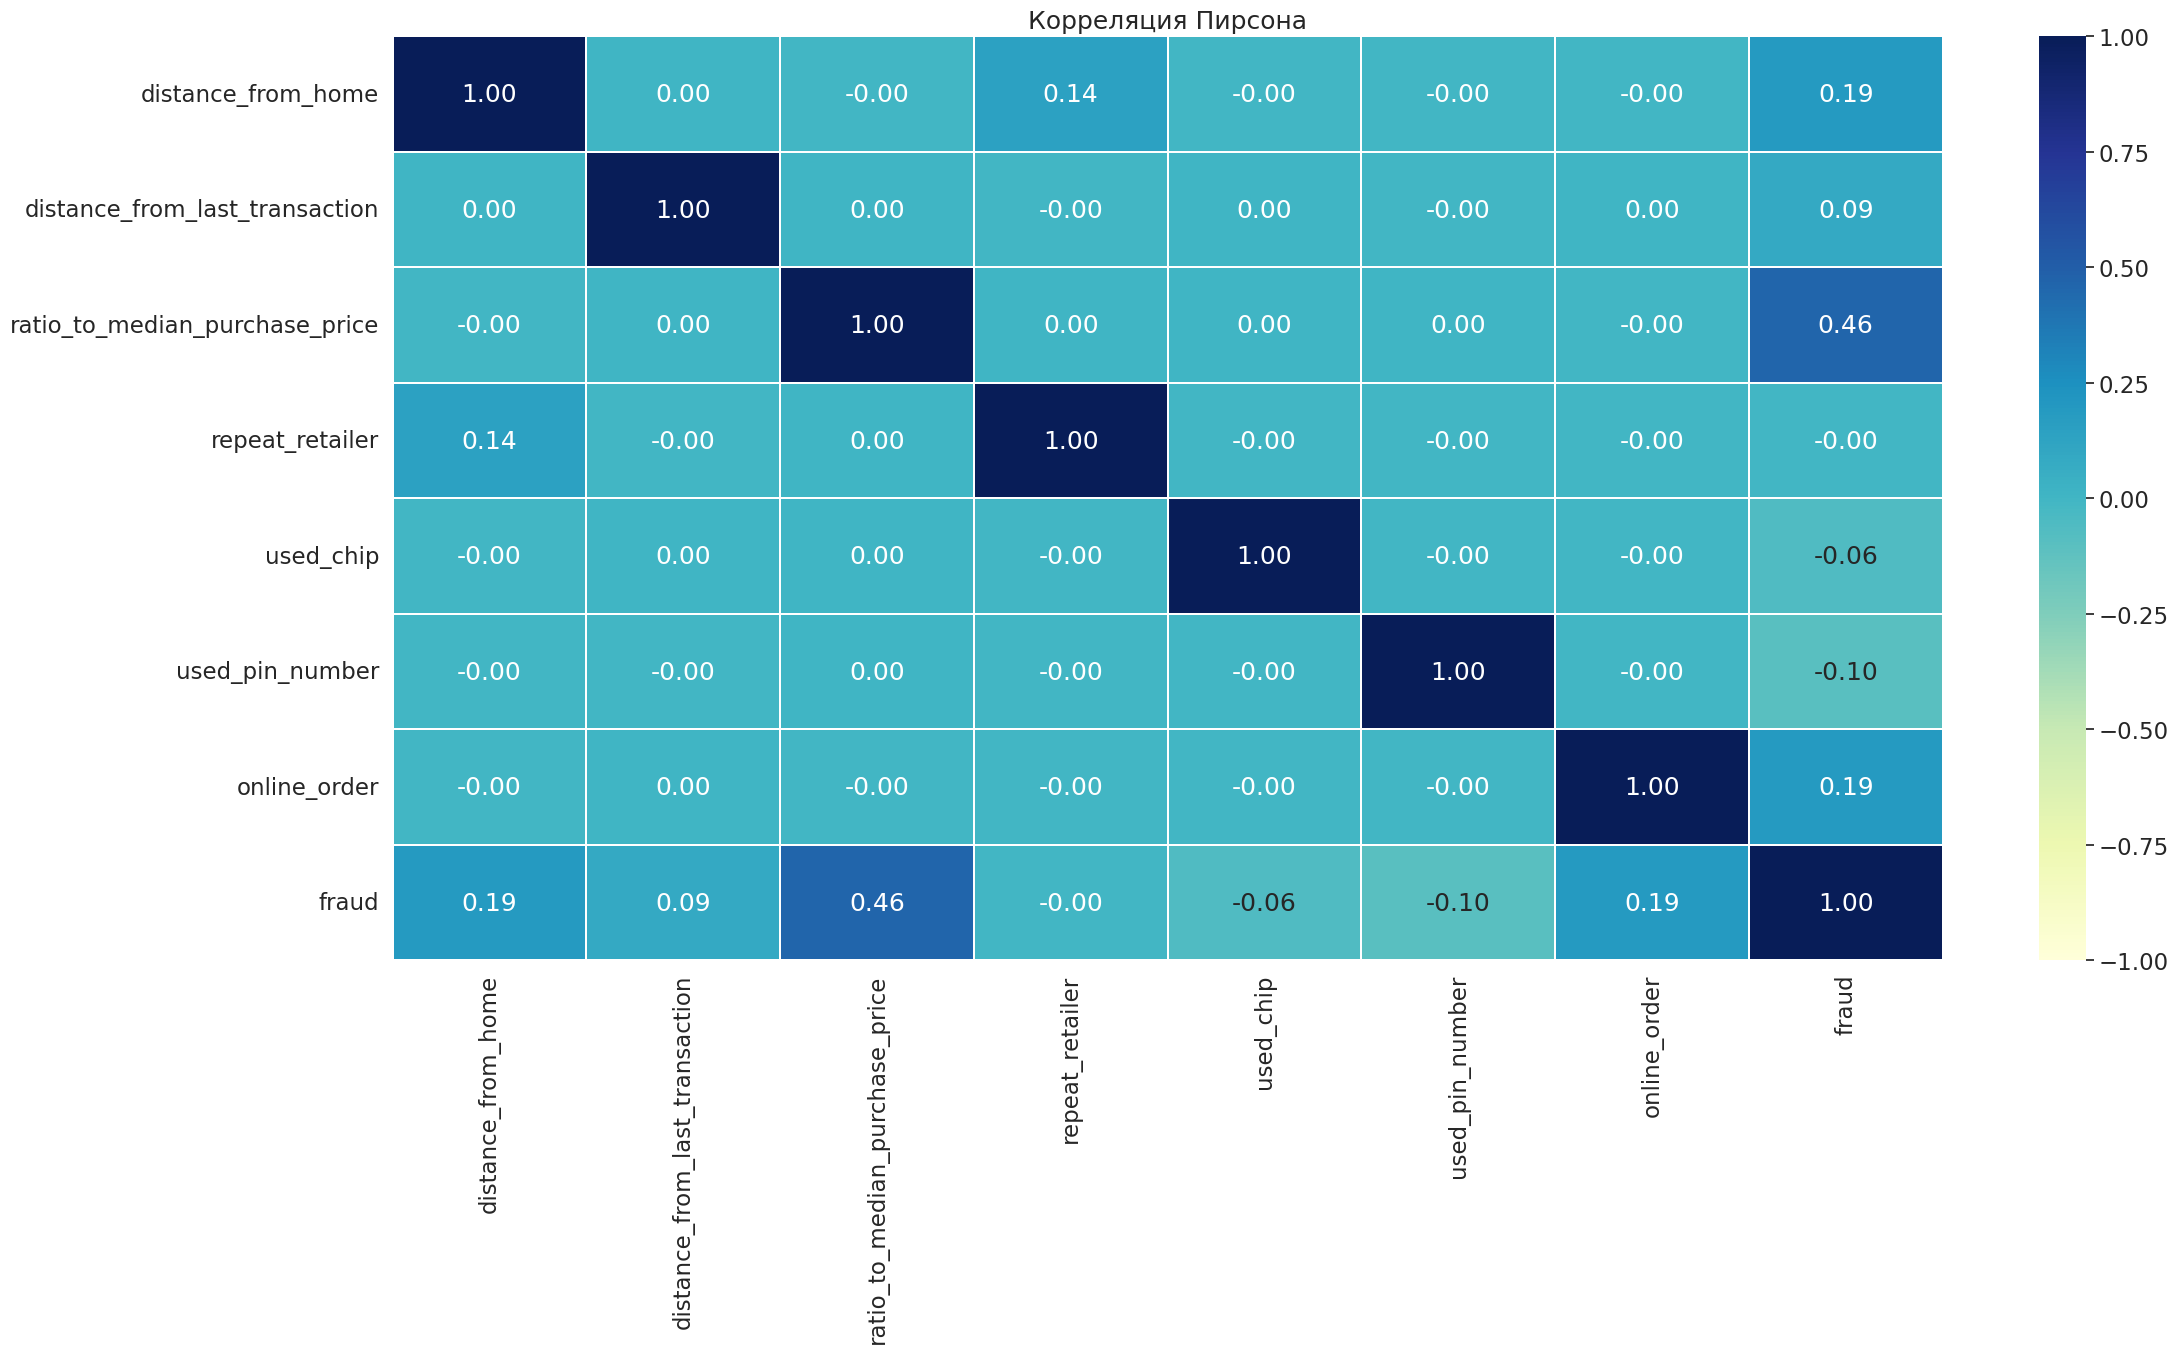

In [ ]:
# Вычисляем матрицу корреляций
corr_matrix = dataset.copy()
plt.figure(figsize=(25,12),dpi=100)

corr_matrix = corr_matrix.corr(method="pearson")
# Визуализируем матрицу корреляции
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.2)
plt.title("Корреляция Пирсона")

#Обработка данных

In [ ]:
# Заменим пробелы на NaN и проверим, сколько пропущеных значений в датасете
dataset = dataset.replace(' ', np.NaN)
np.count_nonzero(dataset.isnull().sum(axis= 1).values)

0

Пропущенные значения отсутствуют

In [ ]:
# Выводим информацию о датасете
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


Категориальные переменные отсутствуют

Нормализуем данные

In [ ]:
X = dataset.copy()

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=dataset.columns, index=dataset.index)
X.head() # Смотрим, как прошла нормализация

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.005443,0.000026,0.007250,1.0,1.0,0.0,0.0,0.0
1,0.001018,0.000015,0.004816,1.0,0.0,0.0,0.0,0.0
2,0.000478,0.000068,0.001581,1.0,0.0,0.0,1.0,0.0
3,0.000211,0.000473,0.001338,1.0,1.0,0.0,1.0,0.0
4,0.004156,0.000048,0.008284,1.0,1.0,0.0,1.0,0.0


Выведем параметры нашего датасета

In [ ]:
X.shape

(1000000, 8)

In [ ]:
X.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.002504,0.000425,0.006795,0.881536,0.350399,0.100608,0.650552,0.087403
std,0.006150,0.002181,0.010454,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000364,0.000025,0.001760,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000937,0.000084,0.003709,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.002421,0.000283,0.007812,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Разделение на обучающую и тестовую выборки

In [ ]:
# Разделяем на тестовую и обучающую выборки
X_train, X_test = train_test_split(X, test_size=0.3, random_state=12)
X_train = X_train[X_train.fraud == 0] # Обучать будем на клиентах, которые не ушли
X_train = X_train.drop(['fraud'], axis=1) # Удаляем целевую перменную
y_test = X_test['fraud'] # Целевая переменная
X_test = X_test.drop(['fraud'], axis=1) # Удаляем целевую перменную

# Получаем значения
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
# Размер тестовой выборки
print(y_test.size)


300000


# Строим и обучаем модель модель

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7, 5),
            nn.Tanh(),
            nn.Linear(5, 3),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(3, 5),
           nn.Tanh(),
           nn.Linear(5, 7),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().double()

In [ ]:
num_epochs = 50   # Количество эпох в автоэнкодере. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32 # Размер мини-пакета, который подаётся в алгоритм. Должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценки градиента для всей обучающей выборки
learning_rate = 1e-3 # На сколько сильно обновляются параметры модели (градиент) на каждом шаге. Чем выше значение, тем медленне обучение

In [ ]:
# Представляет данные в виде мини-пакетах и управляет загрузкой данных для эффективного обучения модели
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [ ]:
# Функция ошибок
criterion = nn.MSELoss()
# Создаётся оптимизатор, который обновляет параметры модели (градиентный спуск)
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=5e-05)


In [ ]:
# Словарь со списком ошибок для обучающей выборки
history = {}
history['train_loss'] = []

In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        # Вычисление ошибки
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        # Оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h) # Вычисление средней ошибки
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/50], loss:0.0111
epoch [2/50], loss:0.0036
epoch [3/50], loss:0.0036
epoch [4/50], loss:0.0022
epoch [5/50], loss:0.0001
epoch [6/50], loss:0.0000
epoch [7/50], loss:0.0000
epoch [8/50], loss:0.0000
epoch [9/50], loss:0.0000
epoch [10/50], loss:0.0000
epoch [11/50], loss:0.0000
epoch [12/50], loss:0.0000
epoch [13/50], loss:0.0000
epoch [14/50], loss:0.0000
epoch [15/50], loss:0.0000
epoch [16/50], loss:0.0000
epoch [17/50], loss:0.0000
epoch [18/50], loss:0.0000
epoch [19/50], loss:0.0000
epoch [20/50], loss:0.0000
epoch [21/50], loss:0.0000
epoch [22/50], loss:0.0000
epoch [23/50], loss:0.0000
epoch [24/50], loss:0.0000
epoch [25/50], loss:0.0000
epoch [26/50], loss:0.0000
epoch [27/50], loss:0.0000
epoch [28/50], loss:0.0000
epoch [29/50], loss:0.0000
epoch [30/50], loss:0.0000
epoch [31/50], loss:0.0000
epoch [32/50], loss:0.0000
epoch [33/50], loss:0.0000
epoch [34/50], loss:0.0000
epoch [35/50], loss:0.0000
epoch [36/50], loss:0.0000
epoch [37/50], loss:0.0000
epoch [38/

Посмотрим, насколько быстро уменьшается ошибка

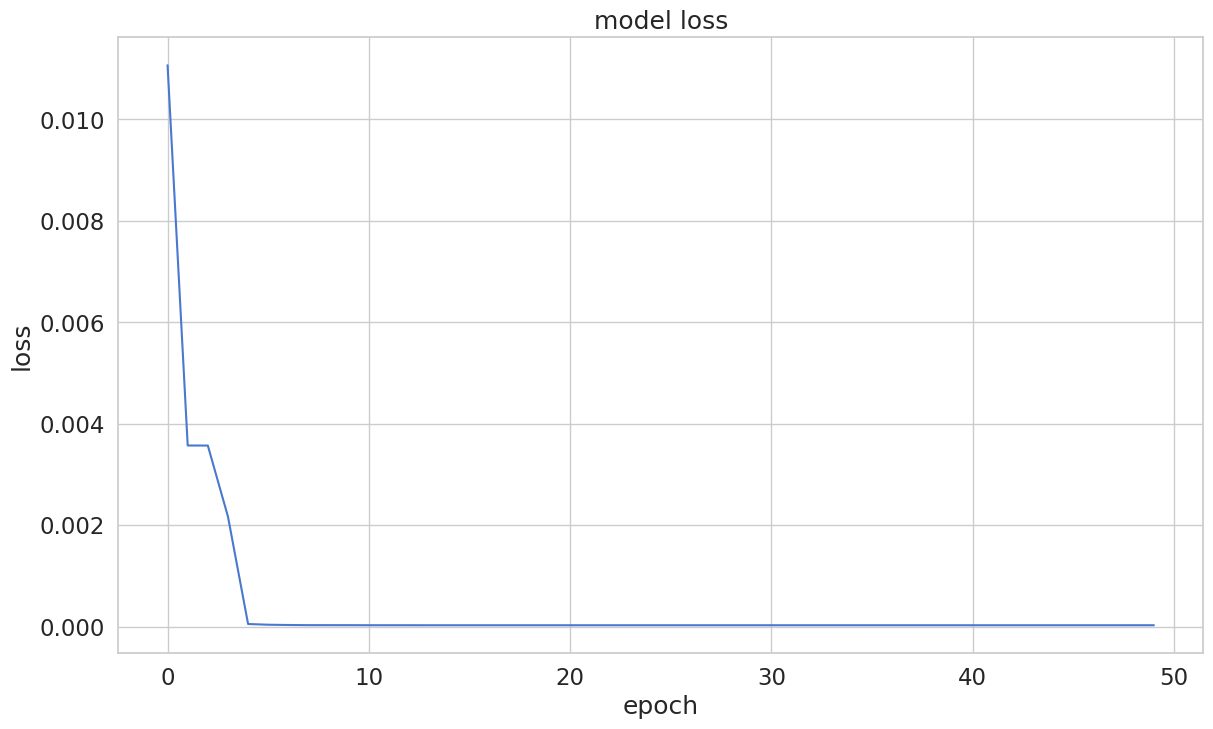

In [ ]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Предсказание значений на тестовой выборке

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        # Подаём в модель тестовые данные
        inputs = data
        outputs = model(inputs)
        # Вычисляем ошибку
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
# Создаём датасет из результатов ошибок и значений целевой переменной
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['fraud'] = y_test

Смотрим, что получилось

In [ ]:
reconstructionErrorDF.head(20)

,pred_loss,fraud
0,0.000005,0.0
1,0.000005,0.0
2,0.000017,0.0
3,0.000002,0.0
4,0.000005,0.0
5,0.000008,0.0
6,0.000004,0.0
7,0.000005,0.0
8,0.000001,0.0
9,0.000007,0.0


# Ошибки для нормальных транзакций

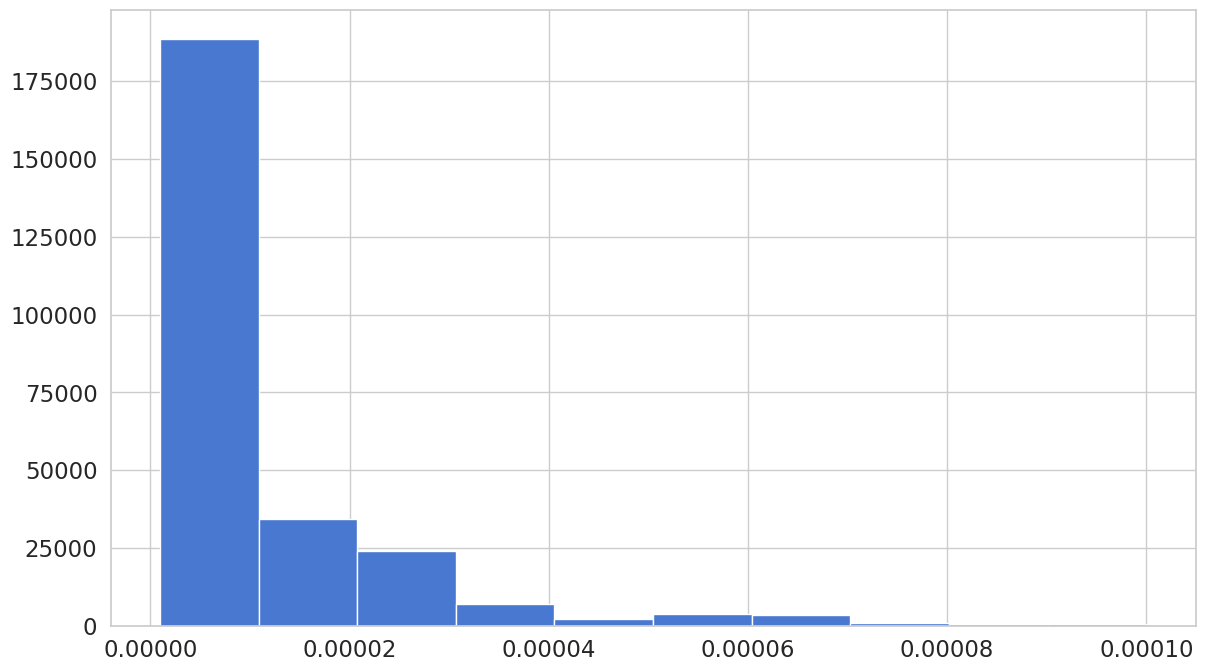

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['fraud']== 0) & (reconstructionErrorDF['pred_loss'] < 0.0001)] # Отбрасываем ошибки больше 0.0001
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Ошибки для мошеннических транзакций

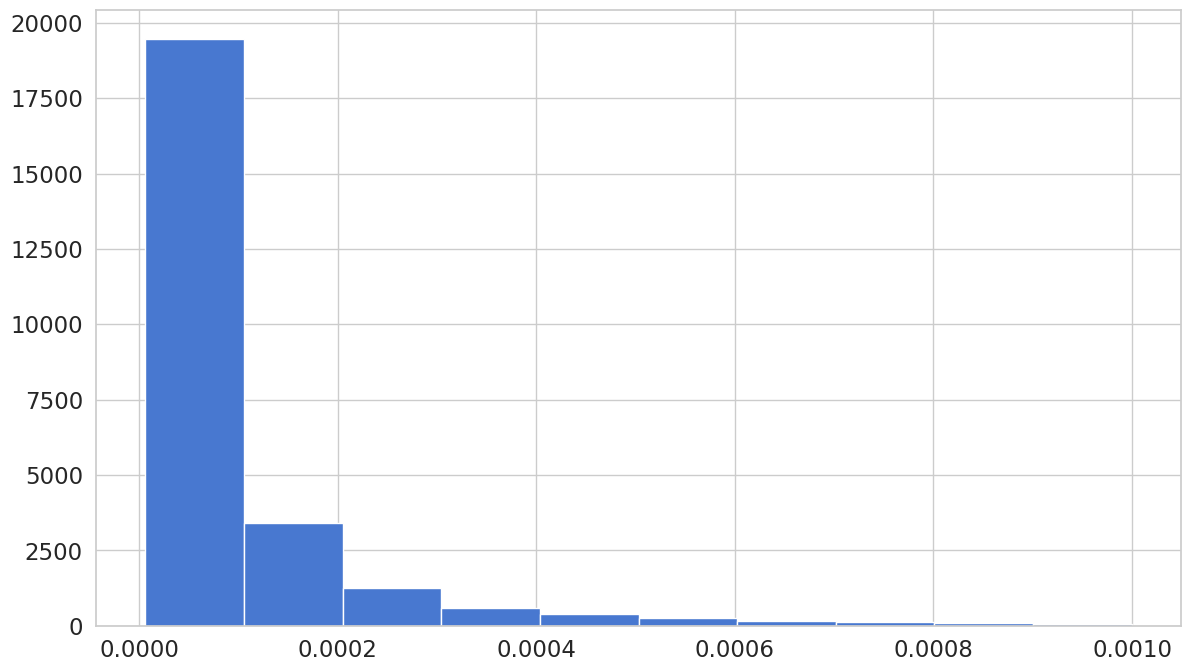

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['fraud']== 1) & (reconstructionErrorDF['pred_loss'] < 0.001)] # Отбрасываем ошибки больше 0.001
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

# ROC Кривые

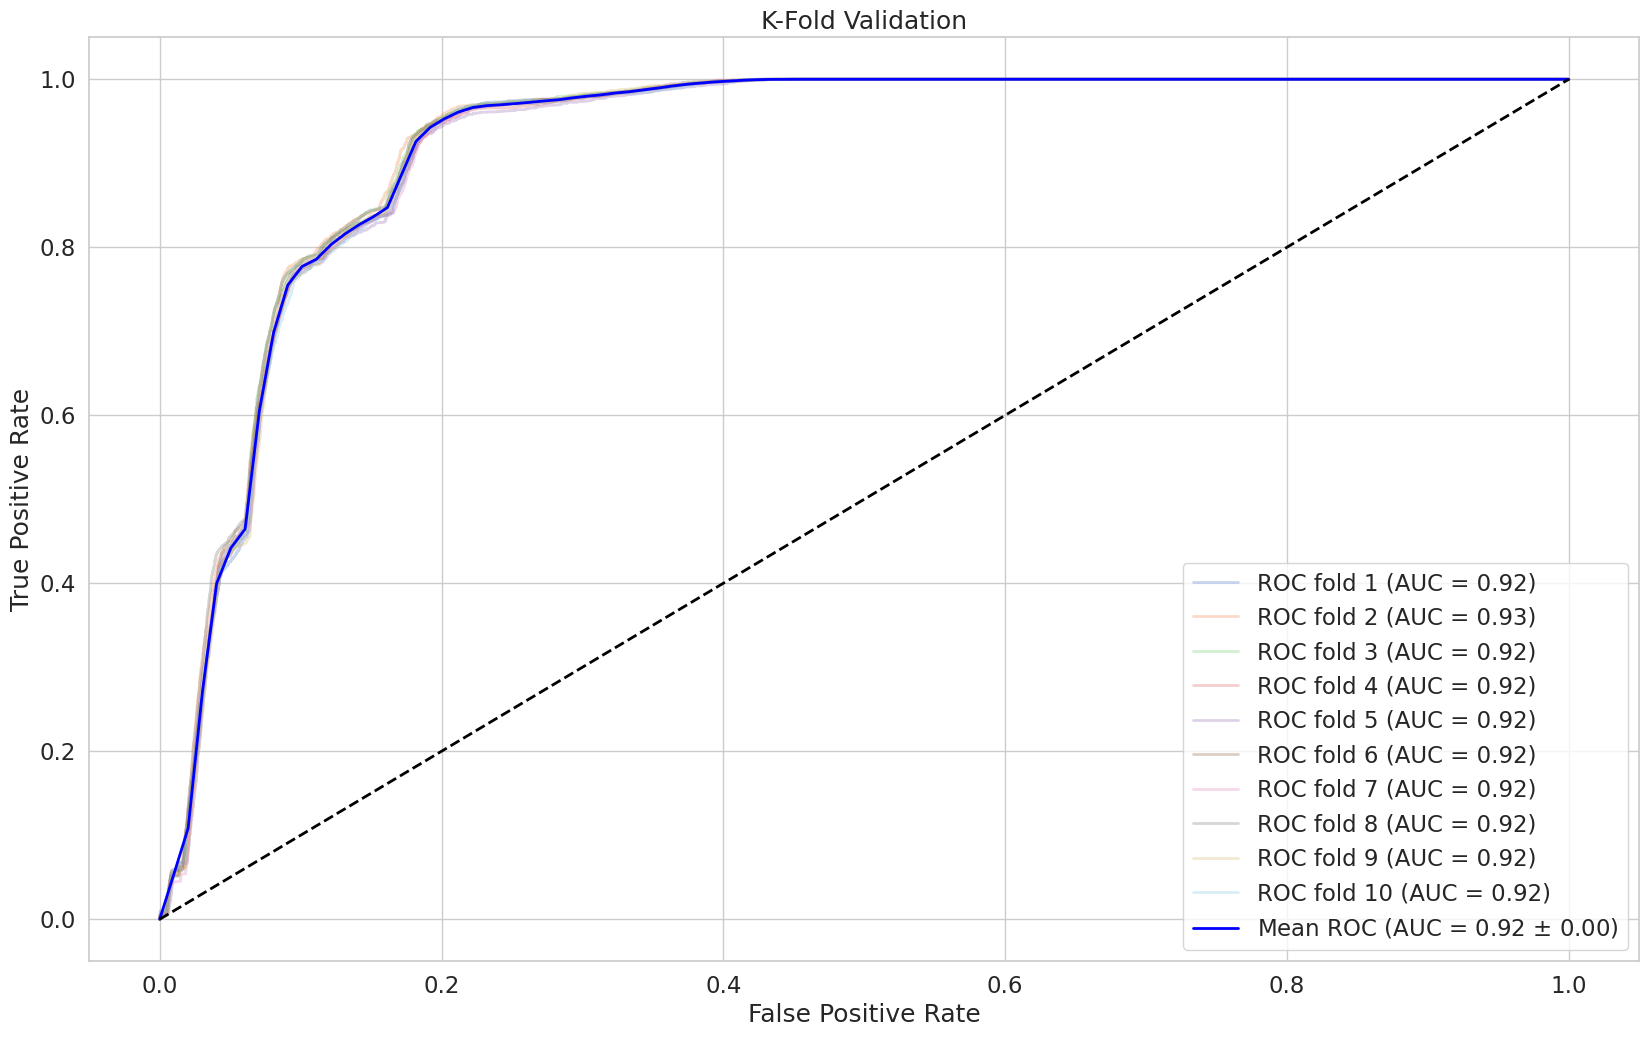

In [ ]:
# Параметры для K-Fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

# Построение семейства ROC-кривых
fig = plt.figure(figsize=(20, 12), dpi=100)
i = 1

for train_idx, test_idx in cv.split(X_test, y_test):
    # Разделяем данные на обучающие и тестовые для текущей итерации
    X_train_fold = X_test[train_idx]
    y_train_fold = y_test[train_idx]
    X_test_fold = X_test[test_idx]
    y_test_fold = y_test[test_idx]

    # Рассчитываем ошибки реконструкции для тестовой выборки
    model.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for data in X_test_fold:
            data = torch.tensor(data).unsqueeze(0).double()
            outputs = model(data)
            loss = criterion(outputs, data).item()
            reconstruction_errors.append(loss)

    # Строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test_fold, reconstruction_errors, pos_label=1)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    i += 1

# Средние значения и доверительный интервал
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=1)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

# Precision vs Recall

Посмотрим как взаимосвязаны precision и recall

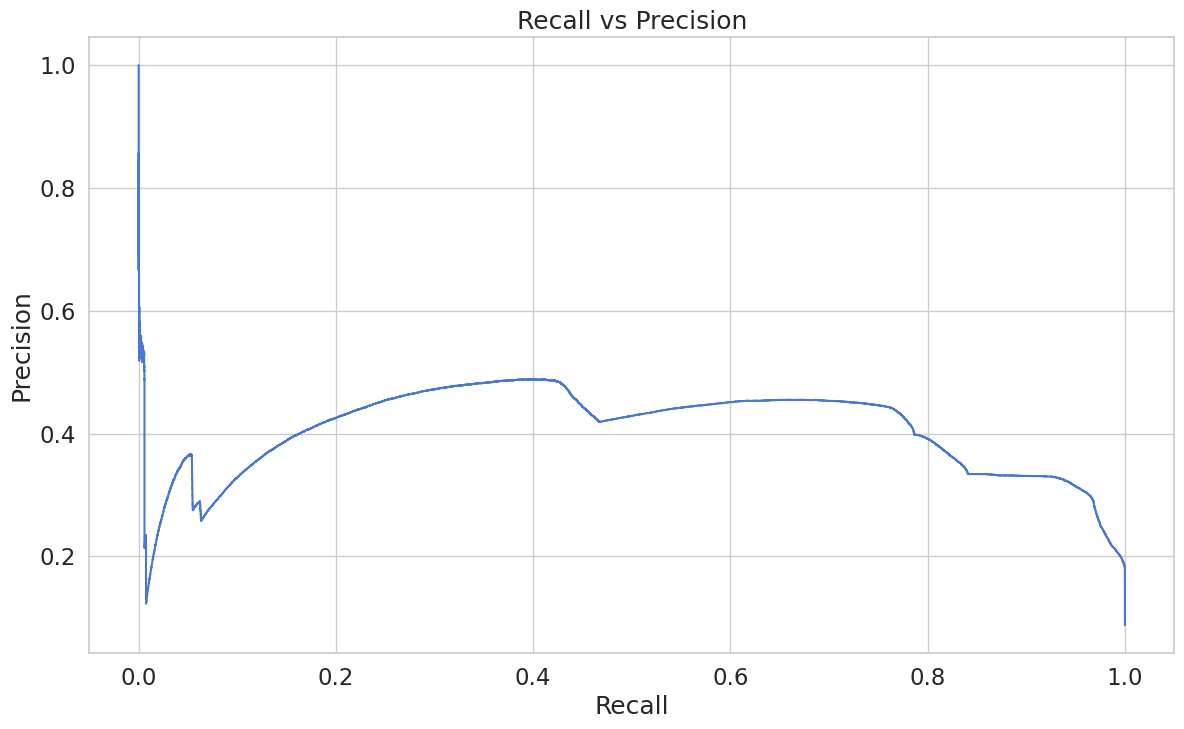

In [ ]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.fraud, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Выберем наилучшее значение трэшхолда для precision и recall

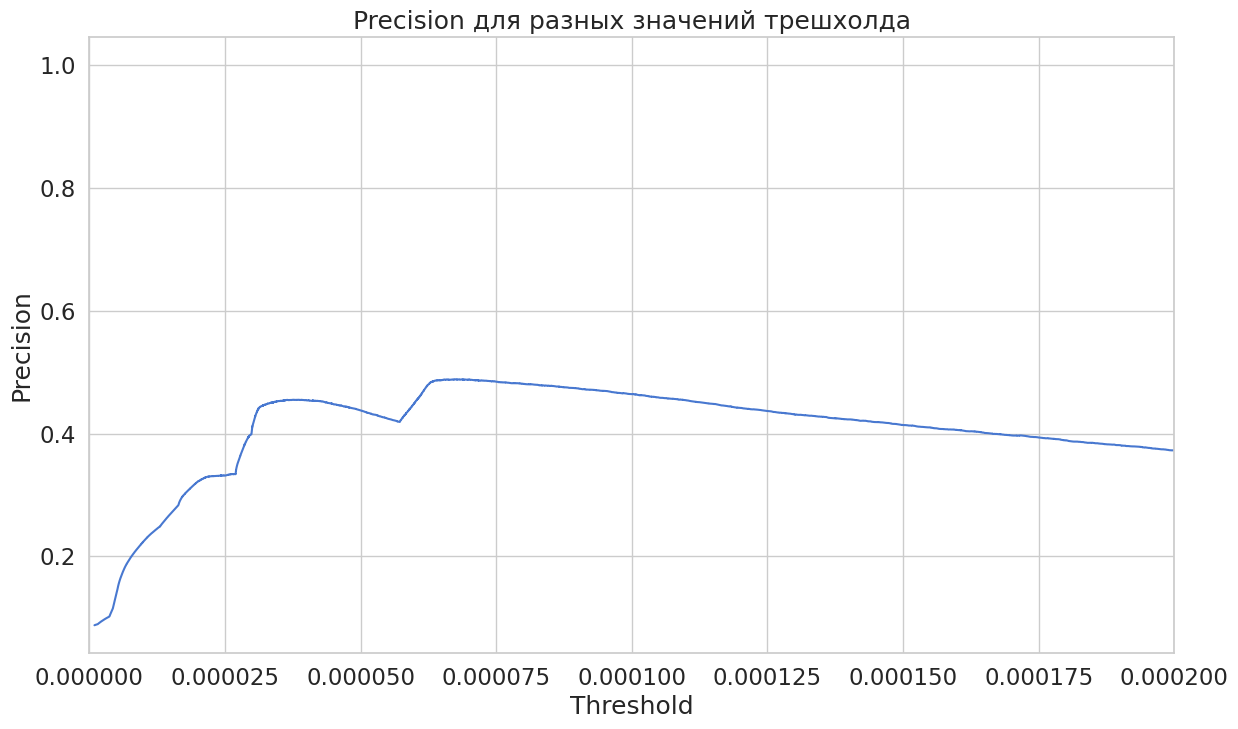

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.xlim([0, 0.0002])
plt.show()

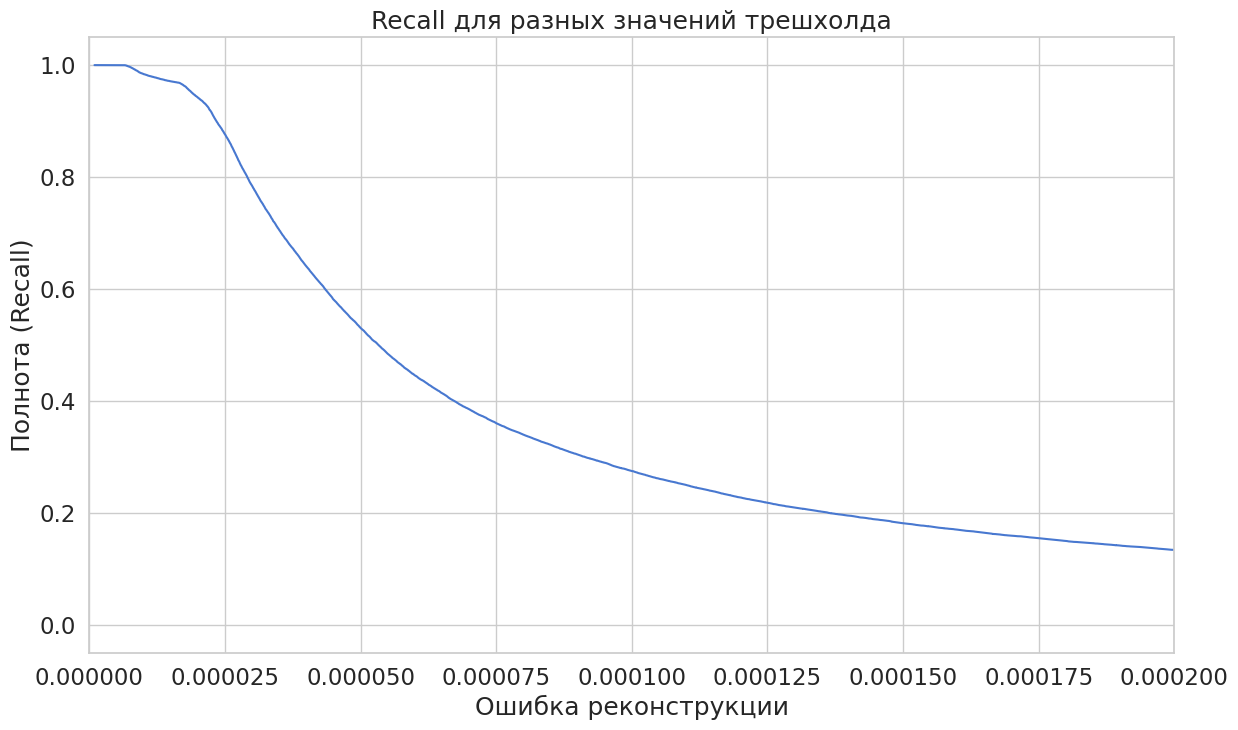

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Полнота (Recall)')
plt.xlim([0, 0.0002])
plt.show()

Видно, что наибольшая полнота при максимальном precision достигается при трэшхолде от 0.00025 до 0.00035

# Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает порог (трэшхолд), мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Выберем трэшхолд исходя из графиков precision и recall.

In [ ]:
threshold = 0.000027

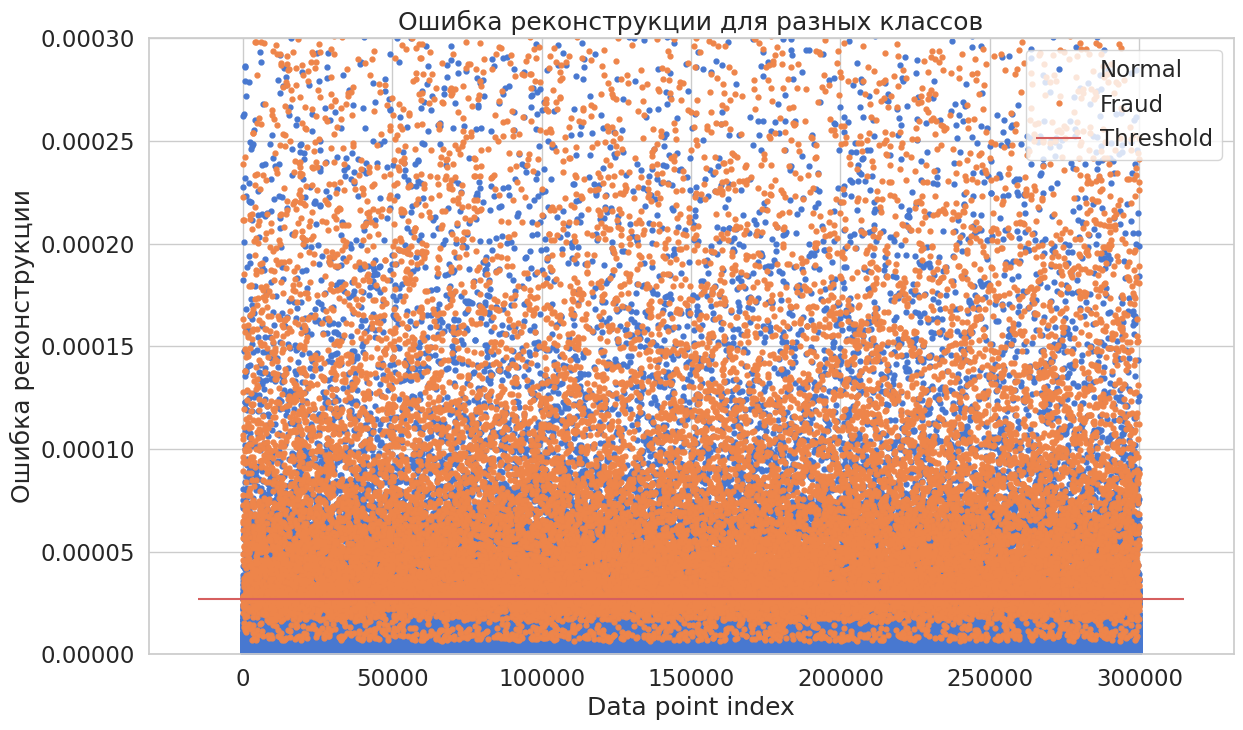

In [ ]:
groups = reconstructionErrorDF.groupby('fraud') # Группируем по 2 классам
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.ylim([0, 0.0003])
plt.show();

Построим и посмотрим confusion matrix:

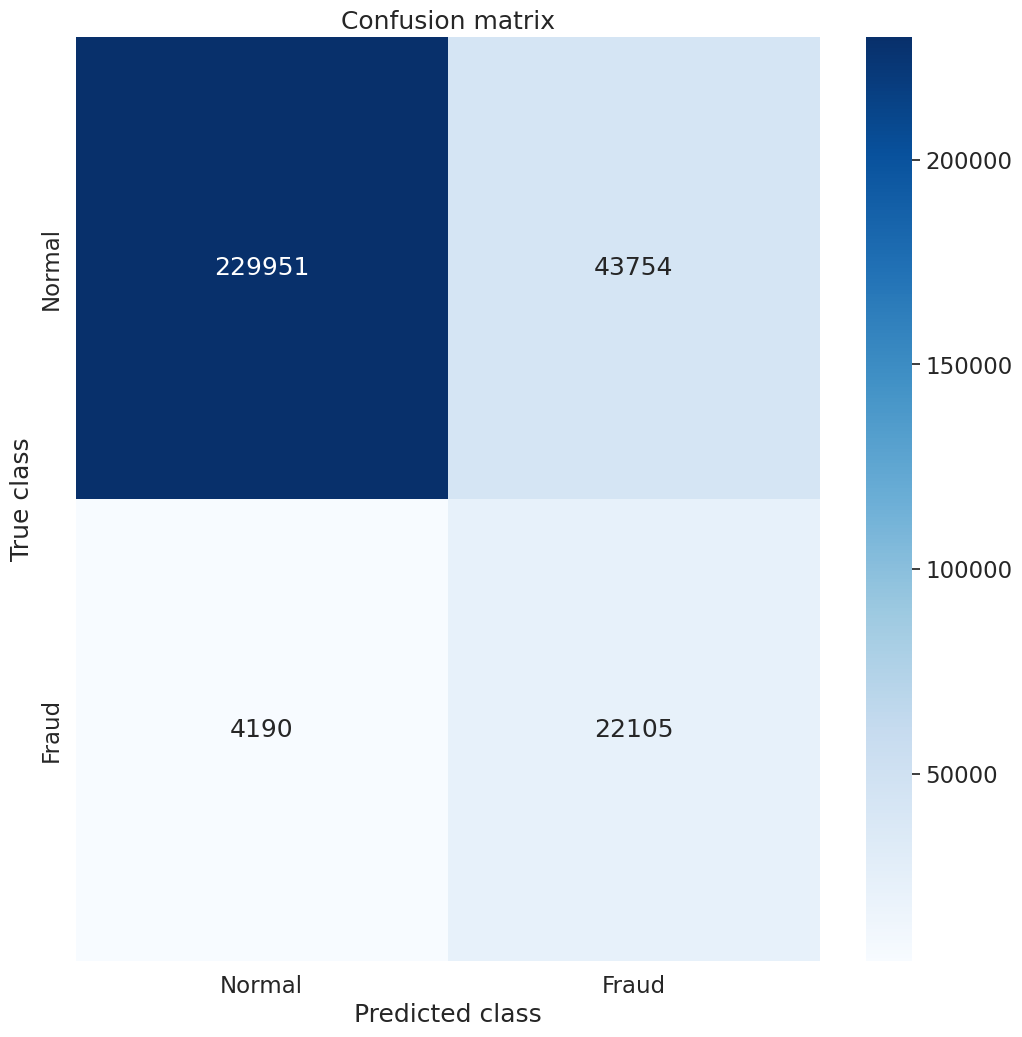

In [ ]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.fraud, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Посмотрим точность предсказаний для различных классов

In [ ]:
print(f'Точность предсказания мошеннических транзакций - {(conf_matrix[1, 1]) / float(conf_matrix[1, 0] + conf_matrix[1, 1])}')
print(f'Точность предсказания нормальных транзакций - {(conf_matrix[0, 0]) / float(conf_matrix[0, 1] + conf_matrix[0, 0])}')

Точность предсказания мошеннических транзакций - 0.8406541167522342
Точность предсказания нормальных транзакций - 0.8401417584625783


Это был выбран трэшход для баланса предсказания обоих классов

Если нам нужно уменьшить вероятность того, что мошенническая транзакция будет принята за нормальную, то нужно уменьшить трэшхолд

In [ ]:
threshold = 0.000020

In [ ]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.fraud, y_pred)
print(f'Точность предсказания мошеннических транзакций - {(conf_matrix[1, 1]) / float(conf_matrix[1, 0] + conf_matrix[1, 1])}')
print(f'Точность предсказания нормальных транзакций - {(conf_matrix[0, 0]) / float(conf_matrix[0, 1] + conf_matrix[0, 0])}')

Точность предсказания мошеннических транзакций - 0.942156303479749
Точность предсказания нормальных транзакций - 0.8089512431267241


Но в этом случае больше нормальных транзакций будут определены как мошеннические

Если же нам важно, чтобы нормальные транзакции не помечались мошенническими, нужно увеличить значение трэшхолда

In [ ]:
threshold = 0.000031

In [ ]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.fraud, y_pred)
print(f'Точность предсказания мошеннических транзакций - {(conf_matrix[1, 1]) / float(conf_matrix[1, 0] + conf_matrix[1, 1])}')
print(f'Точность предсказания нормальных транзакций - {(conf_matrix[0, 0]) / float(conf_matrix[0, 1] + conf_matrix[0, 0])}')

Точность предсказания мошеннических транзакций - 0.7676744628256322
Точность предсказания нормальных транзакций - 0.9050583657587549


# Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях.

Также мы можем выставлять параметр (трэшхолд) и в зависимости от нашей задачи можем достичь либо точности определения мошеннических транзакций, либо точности определения нормальных транзакций, либо установить баланс между ними.